# Preparación del entorno

Como casi siempre, hay que cargar algunas cositas antes de trabajar.
En este caso vamos a instalar el paquete `mglearn`, complemento del libro
de Müller & Guido que seguimos en el curso.


In [1]:
#
# paquete con utilidades y código del libro
# de Andreas Müller & Sarah Guido
#
!pip install mglearn
import mglearn

import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 11.5 MB/s eta 0:00:00


# Regresión

En sentido general, el término _regresión_ refiere al problema clásico de estadística de _estimar relaciones_ entre un conjunto de variables $X_1,X_2,\ldots,X_m$ y una respuesta $y$.

En el contexto de aprendizaje automático, esto se considera un caso particular del problema de aprendizaje supervisado, y como tal suele ser tratado dentro de este tema.

## Problema de ejemplo

A continuación veremos varios métodos de regresión aplicados a un mismo problema sintético similar al que utiliza el libro en el Capítulo 2.
Concretamente, vamos a tomar muestras _ruidosas_ de una _onda sinusoidal_, es decir, nuestras observaciones van a ser de la forma $y = \sin x + z$, donde $z$ es ruido Gaussiano de media nula $\mu=0$ y desviación $\sigma=0.3$. En la celda de código de abajo vemos cómo definir una función que genere estos datos, tomamos algunas muestras y las dibujamos:



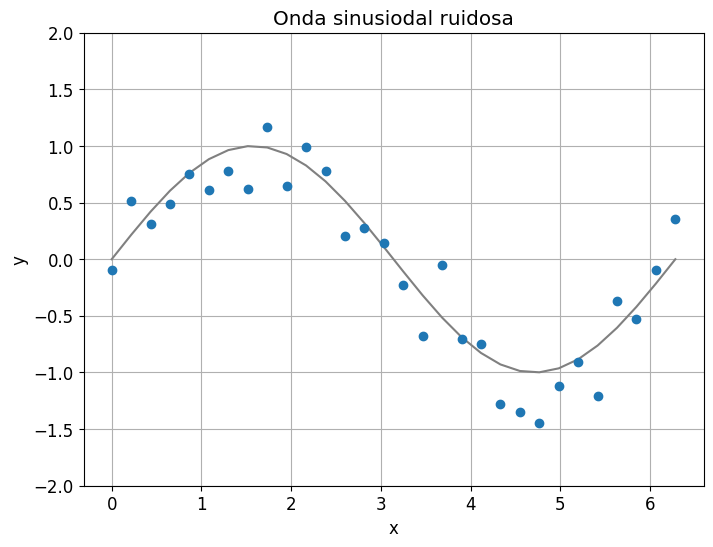

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng

def onda_ruidosa(num_muestras,amplitud=1,frecuencia=1,fase=0,ruido=0,semilla=44441111):
  '''
  genera muestras de una onda sinusoidal de amplitud, frecuencia y fase
  deseadas, con una cantidad de ruido específica
  '''
  rng.seed(semilla)
  X = np.ones((num_muestras,1))
  X = np.linspace(0,2*np.pi,num=num_muestras)
  y = amplitud*np.sin(frecuencia*X+fase) + ruido*rng.randn(num_muestras)
  X = X.reshape(1,-1).T # detalle técnico oscuro y que no aporta nada
  return X,y

#
# dataset sintético para regresión
#
N = 30
X, ytilde = onda_ruidosa(num_muestras=N,ruido=0.0)
X, y      = onda_ruidosa(num_muestras=N,ruido=0.3)

plt.plot(X, ytilde, '-',color=(0.5,0.5,0.5,1.0))
plt.plot(X, y, 'o')
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Onda sinusiodal ruidosa")
plt.grid(True)
plt.savefig('onda_ruidosa.png')
plt.show()


## Regresión lineal

Lo primero que veremos son regresiones lineales. En este caso, la relación a estimar es de la forma $$Y(X) = a_1 X_1 + a_2 X_2 + \ldots + a_m X_m + b.$$
Lo que se _aprende_ en este caso son los _coeficientes_ $a_1,a_2,\ldots,a_m$ y $b$.

La manera más tradicional y simple de realizar dicha estimación es mediante el método de _mínimos cuadrados_ (LS, por _least squares_). Dado un conjunto de entrenamiento compuesto por $n$ pares _entrada-salida_ $(x_j,y_j)$, $j=1,\ldots,n$, los coeficientes LS se calculan de forma que la siguiente suma de _residuos cuadráticos_ sea mínima:

$$\sum_{j=1}^n \left[ \left( \sum_{i=1}^m a_ix_{ji} + b\right) - y_j \right]^2$$

El problema presentado por este método tiene una solución muy simple y cualquier software o paquete de estadística es capaz de calcularla. En la siguiente celda vemos cómo utilizar las funciones de `sklearn` para realizar esta tarea en un caso sintético unidimiensional. Aquí $X$ es una sóla variable y lo que tenemos que estimar son sólo dos parámetros:

$$y = ax + b.$$

## División entre conjunto de entrenamiento y validación

Aquí vemos un primer ejemplo de cómo validar un modelo. Nuestro objetivo es ver qué tan bien se ajusta nuestro modelo a _nuevos_ datos. Entonces, no es buena idea hacer esa valoración sólo con los datos que usamos para entrenar. Para evitar caer en esa trampa, no queda otra alternativa que dividir el conjunto de datos que tenemos para entrenar en _dos_ subconjuntos: uno para el ajuste de los coeficientes, y otro para _probar_ (_testear_) nuestro modelo.



In [ ]:
#
# traemos (importamos) funciones de Scikit para:
# - separación de datos en entrenamiento y validación
#
from sklearn.model_selection import train_test_split
#
# - calcular regresión lineal
#
from sklearn.linear_model import LinearRegression

#
# regresión lineal via mínimos cuadrados ordinarios (OLS)
#
# y = a_1x + a_0
#
#
# separamos datos en entrenamiento y validación:
#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#
# ajustamos con datos de entrenamiento:
#
# a) se crea el modelo lineal
lr = LinearRegression()
#
# b) se ajusta a los datos
#
lr.fit(X_train, y_train)
#
# vemos el resultado
#
a = lr.coef_[0]
b = lr.intercept_
print( f"y(x) = {a:5.3f} x + {b:6.3f}" )
#
# ajuste a datos de entrenamiento y validación
#
y_train_pred = a * X_train[:,0] + b
y_test_pred  = a * X_test[:,0] + b




y(x) = -0.273 x +  0.716


## Medida de desempeño

Una vez que realizamos el ajuste, lo siguiente es ver qué tan bien funcionó. Lo que sigue son dos pequeñas funciones que calculan dos medidas de desempeño para este problema. La primera, la _suma de residuos cuadrados_ o _residual sum of squares_ (RSS), es una muy común.

En estadística clásica se utiliza también la medida llamada $R^2$. Esto no es otra cosa que el RSS dividido por la _suma total de cudrados_, es decir, la suma de los valores al cuadrado de $y$ tal cual vienen. Esto nos da una medida relativa de cuánto logramos _explicar_ o _capturar_ de la función original con nuestro modelo de regresión. Si logramos un $R^2=1$, quiere decir que nuestro ajuste es perfecto. Por otro lado, mientras más bajo $R^2$, peor.

Tal como dijimos en el apartado anterior, el RSS y el $R^2$ se evalúan tanto en el conjunto de entrenamiento como en el de validación o testeo -- si bien la última palabra tiene el de testeo, calcular ambos valores nos da más información; ya veremos cómo.

La siguiente celda define un par de funciones para calcular el RSS y el R2, las aplica a los conjuntos de entrenamiento y test, y luego grafica los resultados.




RSS de entrenamiento: 7.377667938391153
RSS de validación   : 2.2415224036390278
R2  de entrenamiento: 0.4328204970900551
R2  de validación   : 0.44628978252037754
R2 (sklearn) de test: 0.43
R2 (sklearn) de val.: 0.45


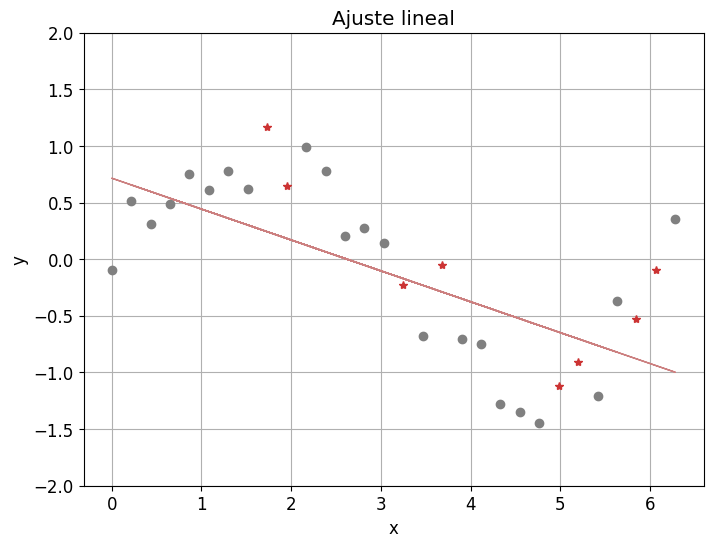

In [ ]:
def rss(ypred,ytrue):
  '''
  Suma de Residuos al Cuadrado
  Residual Sum of Squares (RSS)
  '''
  return np.sum((ypred-ytrue)**2)


def r2(ypred,ytrue):
  '''
  score de ajuste de regresión

     R2 = (1-RSS/TSS)

  donde

    RSS: suma de residuos al cuadrado: sum_i (ypred_i - ytrue_i)
    TSS: suma de valores al cuadrado

  * Mientras más grande, mejor
  * El máximo valor es 1 (error 0)
  * No tiene mínimo (el modelo puede ser arbitrariamente malo)

  esto es lo mismo que calcula la función 'score' del regresor lineal,
  lo implementamos de nuevo aquí por razones ilustrativas.
  '''
  RSS = np.sum((ypred-ytrue)**2)
  TSS = np.sum( (ytrue-np.mean(ytrue))**2 )
  return 1.0 - RSS/TSS


print('RSS de entrenamiento:',rss(y_train_pred,y_train))
print('RSS de validación   :',rss(y_test_pred, y_test))
print('R2  de entrenamiento:',r2(y_train_pred,y_train))
print('R2  de validación   :',r2(y_test_pred, y_test))
print("R2 (sklearn) de test: {:.2f}".format(lr.score(X_train, y_train)))
print("R2 (sklearn) de val.: {:.2f}".format(lr.score(X_test, y_test)))

plt.plot(X_train, y_train, 'o',color=(0.5,0.5,0.5,1.0))
plt.plot(X_test, y_test, '*',color=(0.8,0.2,0.2,1.0))
plt.plot(X_train, a * X_train + b, '-',color=(0.8,0.5,0.5,1.0),lw=1)

plt.plot()
plt.ylim(-2, 2)
plt.title('Ajuste lineal')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig('ajuste_lineal.png')
plt.show()


## Regresión polinomial

El  ajuste $R^2=0.43$ que obtuvimos sobre los datos de _test_ es _pésimo_. Esto no debería sorprendernos: la función a ajustar está _lejos de ser una linea_. Pero eso es algo que sólo podemos saber en un caso de juguete como este; en la vida real nadie sabe de antemano qué forma tiene una función.

Pero sabemos más: el ajuste a los datos de _entrenamiento también_ es pésimo. Eso nos indica que la función a aproximar está lejos de ser una recta.

Qué podemos hacer? Varias cosas. Lo siguiente que vamos a probar es tal vez lo más clásico: una regresión polinomial.

Qué es una regresión polinomial? Lo más fácil es explicarlo en el caso unidimiensional que venimos trabajando. En lugar de la relación

$$Y = aX + b$$

buscamos la relación:

$$y = a_mx^m + a_{m-1}x^{m-1} + \ldots + a_1x^1 + b$$

Lo anterior se reduce a una regresión lineal común y corriente definiendo las siguientes _variables auxiliares_:

$$X_i = X^i$$

Entonces volvemos al caso general descrito al principio:

$$Y = a_m X_m + a_{m-1}X_{m-1} + \ldots + a_1 X_1 + b$$

que es una regresión lineal entre la variable $Y$ y las variables $(X_1,X_2,\ldots,X_m)$.

El método de resolución  es _exactamente el mismo_. Lo único que hay que hacer es calcular  $x,x^2,\ldots,x^m$ para cada dato $x$.


R2  de entrenamiento: 0.9079309353440957
R2  de validación   : 0.8676849862510801


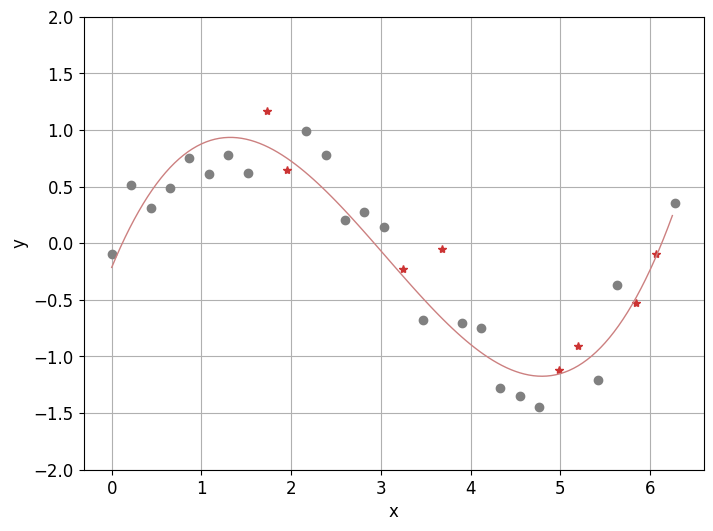

In [ ]:
#
# regresión polinomial de orden 3
#
# y = a_3x^3 + a_2x^2 + a_1x + a_0
#
# definimos características auxiliares
#
# x_1 = x
# x_2 = x^2
# x_3 = x^3
#
# regresión lineal y = f(x_1,x_2,x_3) = a_3x_3 + a_2x_2 + a_1x_1 + a_0
#
X1 = X[:,0]
X2 = X1**2
X3 = X1**3
X = np.zeros((N,3))
X[:,0] = X1
X[:,1] = X2
X[:,2] = X3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr.fit(X_train, y_train)

a = lr.coef_
b = lr.intercept_
#
y_train_pred = a[0] * X_train[:,0] + a[1]*X_train[:,1] + a[2]*X_train[:,2] + b
y_test_pred  = a[0] * X_test[:,0]  + a[1]*X_test[:,1]  + a[2]*X_test[:,2]  + b

print('R2  de entrenamiento:',r2(y_train_pred,y_train))
print('R2  de validación   :',r2(y_test_pred, y_test))

plt.plot(X_train[:,0], y_train, 'o',color=(0.5,0.5,0.5,1.0))
plt.plot(X_test[:,0], y_test, '*',color=(0.8,0.2,0.2,1.0))
xaux = np.arange(0,2*np.pi,step=0.05)
yaux = a[0]*xaux + a[1]*xaux**2 + a[2]*xaux**3 + b
plt.plot(xaux,yaux, '-',color=(0.8,0.5,0.5,1.0),lw=1)

plt.plot()
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig('ajuste_cubico.png')
plt.show()


Vemos que el modelo cúbico que aplicamos logra un ajuste excelente a los datos! Pasamos a tener un $R^2$ superior a $0.85$!

## Complejidad del modelo

Un modelo polinomial es más versátil que uno lineal. Una forma simple de verlo es que los modelos lineales son un caso _particular_ de los modelos polinomiales donde el único coeficiente no nulo es $a_1$.

Usando el mismo argumento, vemos que  la _versatilidad_ de un modelo polinomial de orden más alto es siempre mayor que la de uno de orden más bajo.

Pero lo anterior tiene un precio: al tener más parámetros, el modelo se vuelve más sensible a pequeños detalles espúreos y supérfluos de los datos de entrenamiento.

Ya vimos que pasar de un modelo lineal a uno cúbico ayudó en este caso: el modelo lineal era _demasiado_ simple para el problema. Ahora veremos que también podemos pasarnos par el otro lado: probemos con un polinomio de orden $10$...



R2  de entrenamiento: 0.9809226007883025
R2  de validación   : -1060.1624663114726


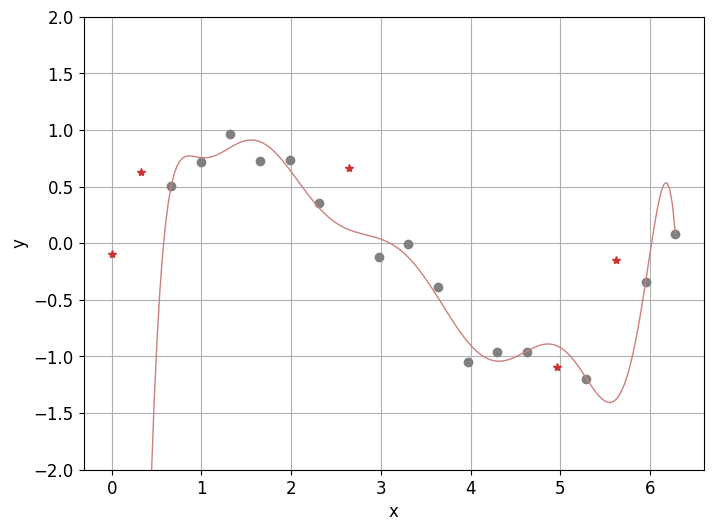

In [ ]:
#
# regresión polinomial de orden 10 (!!)
#
# y = b + \sum_i a_i*x^i
#
# definimos características auxiliares
#
# x_i = x^i
# i = 1,...,10
#
# regresión lineal y = f(x_1,x_2,x_3) = a_3x_3 + a_2x_2 + a_1x_1 + a_0
#
N = 20
X, ytilde = onda_ruidosa(num_muestras=N,ruido=0.0)
X, y      = onda_ruidosa(num_muestras=N,ruido=0.3)

P = 10
x = X[:,0]
X = np.zeros((N,P))
for p in range(P):
  X[:,p] = x**(p+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

modelo_ajustado = lr.fit(X_train, y_train)

a = lr.coef_
b = lr.intercept_
#
y_train_pred = np.dot(X_train,a) + b
y_test_pred  = np.dot(X_test, a) + b

print('R2  de entrenamiento:',r2(y_train_pred,y_train))
print('R2  de validación   :',r2(y_test_pred, y_test))

plt.plot(X_train[:,0], y_train, 'o',color=(0.5,0.5,0.5,1.0))
plt.plot(X_test[:,0], y_test, '*',color=(0.8,0.2,0.2,1.0))

x_aux, _  = onda_ruidosa(num_muestras=10*N,ruido=0.5)
X_aux = np.zeros((10*N,P))
for p in range(P):
  X_aux[:,p] = x_aux[:,0]**(p+1)

y_aux = np.dot(X_aux,a) + b
plt.plot(X_aux[:,0], y_aux, '-',color=(0.8,0.5,0.5,1.0),lw=1)

plt.plot()
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig('sobreajuste.png')
plt.show()


## Sobreajuste

Al aplicar el modelo de orden $10$ obtuvimos un $R^2$ aún mejor en el conjunto de entrenamiento.  Sin embargo, el $R^2$ sobre el conjunto de test es $R^2=-1016$, **horrible**.  Viendo la curva anterior debería ser evidente el por qué: al tener un modelo _tan_ versátil, los parámetros se ajustaron _demasiado_ a los datos de entrenamiento, resultando en una función algo _caprichosa_ y difícil de explicar.

Surge la pregunta entonces de cuál será el polinomio que mejor se ajuste a estos datos. Como primera aproximación al problema vamos a tomar como guía el que resulte en un mejor ajuste a los datos de _test_. Después veremos cómo mejorar este criterio.

El siguiente código sistematiza un poco lo que ya habíamos hecho antes: la función `crear_variables`  crea y devuelve las variables auxiliares  necesarias para ajustar un polinomio de orden $P$ arbitrario.

Luego, en el bucle `for`, probamos polinomios de distintos órdenes, evaluamos su desempeño y lo guardamos en una lista.

Finalmente, buscamos el orden de polinomio para el cual el desempeño reportado es máximo, y declaramos ese orden como el óptimo.


orden  1 R2 train 0.43 test 0.45
orden  2 R2 train 0.43 test 0.46
orden  3 R2 train 0.91 test 0.87
orden  4 R2 train 0.93 test 0.86
orden  5 R2 train 0.94 test 0.85
orden  6 R2 train 0.95 test 0.83
orden  7 R2 train 0.95 test 0.83
orden  8 R2 train 0.96 test 0.44
orden  9 R2 train 0.97 test -0.17
orden 10 R2 train 0.97 test -0.45


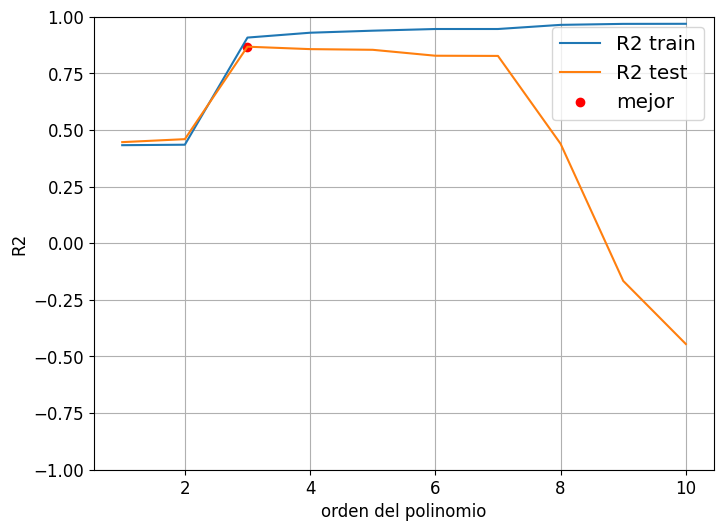

In [ ]:
#
# Ajuste y sobreajuste según complejidad del modelo
#
# cuál es el mejor orden de polinomio para este caso?
#
def crear_variables(x,P):
  '''
  crear variables para regresión polinómica
  para cada dato x, creamos un vector de P
  variables auxiliares

  x -> [x, x^2, x^3, ..., x^P]
  '''
  x = x.ravel()
  N = len(x)
  Xp = np.zeros((N,P))
  for p in range(P):
    Xp[:,p] = x**(p+1)
  return Xp

#
# creamos datos
#
N = 30
x, ytilde = onda_ruidosa(num_muestras=N,ruido=0.0)
_, y      = onda_ruidosa(num_muestras=N,ruido=0.3)
x = x[:,0] # primera columna (única columna)

#
# división en datos de entrenamiento y datos de validación
#
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

#
# repetimos el experimento para polinomios de distinto orden
#
resultados = list()

for p in range(1,11):
  '''
  función auxiliar para repetir experimento
  '''

  Xp_train = crear_variables(X_train,p)
  Xp_test  = crear_variables(X_test,p)
  #
  # ajuste a datos
  #
  lr.fit(Xp_train, y_train)
  a = lr.coef_
  b = lr.intercept_
  #
  # evaluación de polinomio ajustado
  #
  y_train_pred = np.dot(Xp_train,a) + b
  y_test_pred  = np.dot(Xp_test, a) + b
  r2_train = r2(y_train_pred,y_train)
  r2_test  = r2(y_test_pred, y_test)
  print(f'orden {p:2} R2 train {r2_train:0.2f} test {r2_test:0.2f}')
  #
  # terna de resultados para este caso
  #
  resultados.append( (p, r2_train,r2_test) )

#
# armamos los resultados como matriz (util para manipular)
#
A = np.array(resultados)
mejor    = np.argmax(A[:,2]) # lugar del mayor valor de R2 en test, la tercera columna (2)
mejor_R2 = A[mejor,2]        # mayor valor de R2 en test, la tercera columna (2)
mejor_p  = A[mejor,0]        # orden de polinomio correspondiente, la primera columna

plt.plot(A[:,0],A[:,1:])
plt.ylim(-1, 1)
plt.scatter([mejor_p],[mejor_R2],marker='o',color='r')
plt.xlabel("orden del polinomio")
plt.ylabel("R2")
plt.legend( ("R2 train","R2 test","mejor") )
plt.grid(True)
plt.savefig('ajuste_optimo.png')
plt.show()


## Complejidad y cantidad de muestras

El problema que vimos anteriormente es un caso particular de un problema más general y complejo que es la _selección de modelos_.  

En ese caso, dado un conjunto de datos de prueba, vimos que el mejor polinomio que se ajustaba a los datos observados era un polinomio de orden $3$.

Es importante entender que en la práctica no tenemos forma de saber que la función subyacente es una sinusoide o efectivamente un polinomio: simplemente resultó de nuestros experimentos que, de entre todos los poliniomios, el que mejor se ajustó fue el de orden $3$.

Y por qué es importante hacer esa aclaración? Porque el orden del polinomio, o, en general, el modelo que mejor funciona, depende no sólo de la función subyacente (desconocida) del problema, sino de la cantidad de muestras que tenemos. Veremos qué pasa ahora, en el _mismo_ problema, si en lugar de tener $50$ muestras para entrenar tenemos sólamente $3$.

El código de abajo repite el experimento anterior _variando_ el subconjunto de entrenamiento que usamos para ajustar los datos. Para cada subconjunto tendremos un ajuste distinto, y la idea es ver cómo varía el modelo estimado según ese subconjunto.



orden  0 R2 train 0.00 test -0.24
orden  3 R2 train 1.00 test -14.58
orden  0 R2 train 0.00 test -0.01
orden  3 R2 train 1.00 test -7.36
orden  0 R2 train 0.00 test -0.21
orden  3 R2 train 1.00 test 0.11


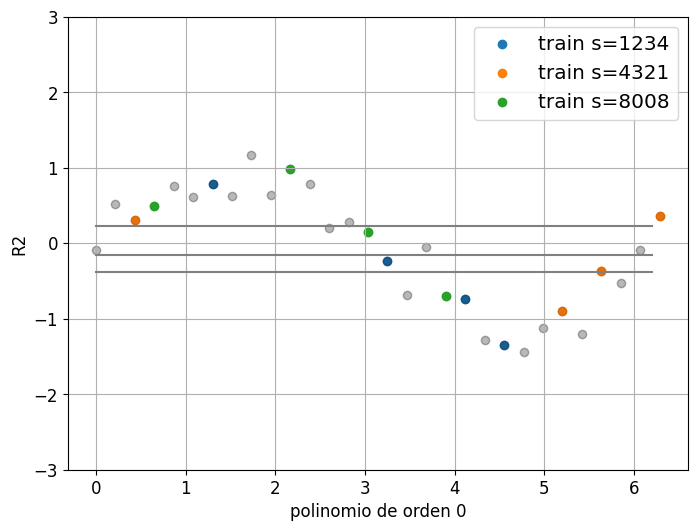

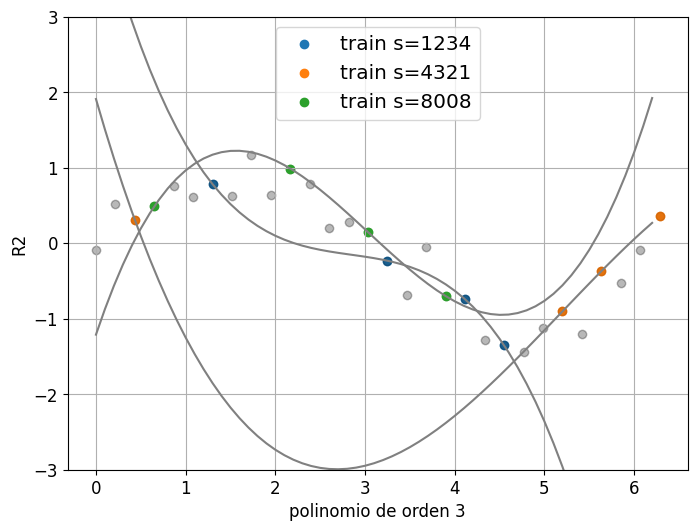

In [ ]:
#
# Ajuste y sobreajuste según complejidad del modelo
#
# pocas muestras vs. muchas muestras
#
# cuál es el mejor orden de polinomio para este caso?
#
#
N = 30
x, ytilde = onda_ruidosa(num_muestras=N,ruido=0.0)
_, y      = onda_ruidosa(num_muestras=N,ruido=0.3)
x = x[:,0] # primera columna (única columna)

x_aux    = np.arange(0,2*np.pi,step=0.1)

#
# repetimos el experimento para distintos subconjuntos de muestras
# de entrenamiento
#
# la semilla es un número entero elegido arbitrariamente que sirve
# para dar un estado inicial al generador de números pseudo-aleatorios
# (para cada número entero se genera una secuencia de números pseudo-aleatorios
# particular y única.)
#
handles = list()
legends = list()

for semilla in (1234,4321,8008):
  #
  # MUY POCAS MUESTRAS DE ENTRENAMIENTO!
  # El mínimo posible para ajustar un polinomio de orden p es p+1!
  #
  #
  X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=4, random_state=semilla)
  #
  # repetimos el experimento para polinomios de orden 1 y 3
  #
  for p in (0,3):

    #
    # ajuste a datos
    #
    if p > 0:
      Xp_train = crear_variables(X_train,p)
      Xp_test  = crear_variables(X_test,p)
      Xp_aux   = crear_variables(x_aux,p)
      modelo_ajustado = lr.fit(Xp_train, y_train)
      a = lr.coef_
      b = lr.intercept_
      y_train_pred = np.dot(Xp_train,a) + b
      y_test_pred  = np.dot(Xp_test, a) + b
      y_aux = np.dot(Xp_aux,a) + b
    else:
      Xp_train = crear_variables(X_train,1)
      Xp_test  = crear_variables(X_test,1)
      Xp_aux   = crear_variables(x_aux,1)
      b = np.mean(y_train)
      y_train_pred = b * np.ones(Xp_train.shape[0])
      y_test_pred  = b * np.ones(Xp_test.shape[0])
      y_aux        = b * np.ones(Xp_aux.shape[0])

    r2_train = r2(y_train_pred,y_train)
    r2_test  = r2(y_test_pred, y_test)
    print(f'orden {p:2} R2 train {r2_train:0.2f} test {r2_test:0.2f}')
    #
    #
    #
    plt.figure(p)
    plt.plot(x_aux,y_aux,color=(0.5,0.5,0.5,1.0))
    plt.scatter(Xp_test[:,0],y_test,color=(0,0,0,0.1))
    h = plt.scatter(Xp_train[:,0],y_train)
    if p > 0:
      handles.append(h)
      legends.append(f'train s={semilla}')


for p in (0,3):
  plt.figure(p)
  plt.ylim(-3,3)
  plt.xlabel(f"polinomio de orden {p}")
  plt.ylabel("R2")
  plt.grid(True)
  plt.legend(handles,legends)
  plt.savefig(f'pocas_muestras_p{p}.png')

plt.show()




## Interpretación de los resultados anteriores

Como resultado tenemos dos gráficas: en cada una de ellas tenemos $3$ ajustes distintos derivados de $3$ subconjuntos de entrenamiento distintos (los puntos azul, naranja y verde).

La primera gráfica corresponde a un ajuste lineal de orden **cero**, es decir, $y = b$ (la variable $X$ no se usa); ese es el modelo lineal más sencillo posible: ajustamos a la función con un valor constante.

La segunda gráfica muestra el ajuste de un polinomio de orden $3$, tal como el que usamos en el estudio anterior.

Podemos ver tres cosas:

*   El polinomio de orden $3$ da _perfecto_ en el conjunto de _entrenamiento_
*   El polinomio de orden $3$  da _mucho peor_ en el conjunto de _test_
*   El $R^2$ del polinomio de orden $3$ da _mucho_ peor que el modelo de orden $0$ sobre el conjunto de _test_.
*   Ninguno de los ajustes del polinomio de orden $3$ se parece ni de asomo al modelo aprendido cuando teníamos $50$ muestras de entrenamiento

La verdad es que todo polinomio de orden $p$ es capaz de ajustarse _perfectamente_ a $p+1$ puntos, y por eso el ajuste es siempre perfecto. Este es el summum del sobreajuste, y la consecuencia esperada es que la generalización es pésima: anda muy mal con datos que no sean los de entrenamiento.

Sorprendentemente, frente a tan pocos datos, lo mejor que podemos hacer es aproximar la función con una constante. C'est la vie.



# Regularización

Del principio de este Notebook podría quedar la idea de que los modelos lineales son muy simples.

Sin embargo, en el fondo, todos los modelos que vimos anteriormente son lineales, sólo que expresados en un espacio de dimensión más alta: para regresión polinomial, transformamos cada dato escalar $x$ en un vector multidimensional de dimensión $p$.

Vimos también que podemos llegar a tener modelos muy complejos con esta metodología.

En resumen, lo que vimos, de manera un poco indirecta, es que los modelos lineales pueden llegar a ser muy complejos, incluso _demasiado complejos_, cuando la cantidad de variables (y por ende la dimensión del problema) es grande.

Vimos también que la complejidad inherente del modelo  (dicho de manera simple, la cantidad de parámetros) juega un rol importante en su capacidad de ajuste (y peligro de sobreajuste) a los datos.

Lo que vamos a ver ahora es cómo _reducir_ o _controlar_ la complejidad de un modelo lineal en dimensiones altas. Esto se llama _regularización_, y tiene varios sabores.

La estrategia general consiste en _promover_, _fomentar_ o bien _restringir_ los valores de lo coeficientes estimados $a_1,a_2,\ldots,a_m$ de manera de que cumplan cierto criterio de _parsimonia_.

Los ejemplos que vamos a ver abajo incluyen al llamado _Ridge Regression_, cuya premisa es que los coeficientes _no sean demasiado grandes_, y el _LASSO_, históricamente mucho más reciente (mediados de los 1990's).

## Dataset: Extended Boston Housing

Para ilustrar los métodos de regularización vamos a introducir un nuevo problema clásico: se trata de estimar el precio de venta $Y$ de una casa en Boston dada una serie de datos $X_1$,$X_2,\ldots,X_m$ relevados sobre la casa, por ejemplo, antigüedad, cercanía al río, entre muchos otros.

El conjunto consta de $104$ datos  para un total de $506$ casas, con sus correspondientes precios de venta.

Primero vemos qué podemos obtener haciendo una regresión lineal común (por mínimos cuadrados). Como siempre, empezamos por partir el conjunto de datos en un subconjunto de entrenamiento y otro de validación.


In [ ]:
!pip install --quiet mglearn
#
# dataset real para regresión
# paquete del libro Müller & Guido (MG)
#
from mglearn import datasets as mgdatasets

#
# - separación de datos en entrenamiento y validación
#
from sklearn.model_selection import train_test_split
#
# - calcular regresión lineal
#
from sklearn.linear_model import LinearRegression,Ridge,Lasso

boston = mgdatasets.load_extended_boston()
X,y = boston
n,m = X.shape
print(f"datos: {n} muestras de dimensión {m} cada una")

#
# regresión lineal via mínimos cuadrados ordinarios (OLS)
#
# y = a_1x + a_0
#
#
# separamos datos en entrenamiento y validación:
#
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=200)
#
# lista de modelos que vamos a probar
#
modelos = {
    'Lineal     ': LinearRegression(),  # modelo lineal
    'Ridge@0.010':Ridge(alpha=0.010),   # Ridge, poca reg.
    'Ridge@0.100':Ridge(alpha=0.100),   # Ridge, ideal
    'Ridge@1.000':Ridge(alpha=1.000),   # Ridge, mucha reg.
    'Ridge@10.00':Ridge(alpha=10.00),   # Ridge, mucha reg.
    'Lasso@.0001':Lasso(alpha=0.0001,max_iter=100000),  # LASSO, poca.
    'Lasso@0.001':Lasso(alpha=0.001,max_iter=100000),  # LASSO, poca.
    'Lasso@0.01':Lasso(alpha=0.01,max_iter=10000),  # LASSO, ideal
    'Lasso@0.1':Lasso(alpha=0.1,max_iter=10000)   # LASSO, mucha
}
#
# repetimos lo siguiente para cada modelo:
#
for nombre in modelos.keys():
  modelo = modelos[nombre]
  # ajuste a los datos:
  modelo = modelo.fit(X_train, y_train)
  # calidad de ajuste:
  R2train = modelo.score(X_train,y_train)
  R2test  = modelo.score(X_test,y_test)
  print(f"{nombre}: train {R2train:5.3f} test {R2test:5.3f}")


datos: 506 muestras de dimensión 104 cada una
Lineal     : train 0.952 test 0.796
Ridge@0.010: train 0.940 test 0.794
Ridge@0.100: train 0.916 test 0.853
Ridge@1.000: train 0.858 test 0.836
Ridge@10.00: train 0.750 test 0.736
Lasso@.0001: train 0.951 test 0.807
Lasso@0.001: train 0.939 test 0.828
Lasso@0.01: train 0.885 test 0.841
Lasso@0.1: train 0.747 test 0.724


## Observaciones

De lo anterior observamos varias cosas:

*   Con el parámetro justo, podemos mejorar significativamente el desempeño en _test_ del modelo (que es el que importa)
*   Si la regularización es muy baja, el desempeño se acerca al de mínimos cuadrados (de hecho es idéntico cuando $\alpha=0$ en ambos casos)
*   Si la regularización es demasiada, el desempeño cae tanto en entrenamiento como en validación: _underfitting_!
*   El valor del parámetro óptimo es muy distinto según el tipo de regularización!

